# Zonnepaneelefficiëntie
**Student:** Tristan Gerritsen \
**Studentnummer:** S1158446

## 1. Business Understanding
We kijken naar zonnepaneeldata over een periode van net iets minder naar twee jaar. De metingen bestaan uit het wattage dat elke minuut door de panelen werd opgewekt. Hierbij is de data al omgezet naar watt per vierkante meter.

We zijn op zoek naar de efficientie van de panelen. Deze kan berekend worden door de theoretische hoeveelheid opbrengst te nemen en deze te verlagen met een bepaalde factor om de werkelijke meting te benaderen. Deze factor is de efficientie.

Om deze berekening te moeten doen, maken we gebruik van de pvlib library. Hierbij is het nodig om de helling van het zonnepaneel met het dak te weten (de tilt). En ook de richting van het paneel (de azimuth). De azimuth loopt van 0 graden noord, naar 90 graden oost, naar 180 graden zuid en dan naar 270 graden west.

## 2. Data Understanding
Vanuit de business heb ik een `dataset.csv`-bestand aangeleverd gekregen, die ik moet gaan onderzoeken. Ook moet ik weersinformatie ophalen van het KNMI, zodat ik deze naast elkaar kan leggen.

### 2.1. Bibliotheken importeren
Om de data te kunnen uitlezen en tonen, maak ik gebruik van de volgende bibliotheken en functies daarin. Ook importeer ik alvast `scipy` voor later.

In [49]:
%pip install historicdutchweather pvlib


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [17]:
# Imports
import pandas as pd
import seaborn as sns
# import historicdutchweather
import pytz
from typing import Tuple
import pvlib
from datetime import datetime
from scipy.optimize import minimize
import matplotlib.pyplot as plt

Zorg ervoor dat we in de juiste map zitten:

In [18]:
import os
if '.devcontainer.json' in os.listdir("."):
    os.chdir("Thema 1/Huiswerk/huiswerkopgave optimalisatie/")
os.listdir()

['dataset.csv', 'Studentenversie Tristan Gerritsen.ipynb', 'weather.csv']

### 2.2. Dataset inladen
Aangeleverd is een dataset, waarin we zien dat het bestaat uit een bepaald tijdopname (die ik omzet naar de juiste _pandas datetime_), samen met een lezing van het wattage dat op dat moment geproduceerd werd.

In [19]:
df_production = pd.read_csv('dataset.csv')
df_production['time'] = pd.to_datetime(df_production['time'])

In [20]:
df_production.info()
df_production.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1266008 entries, 0 to 1266007
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype              
---  ------      --------------    -----              
 0   time        1266008 non-null  datetime64[ns, UTC]
 1   production  1266008 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 19.3 MB


,time,production
0,2020-04-10 10:31:35+00:00,96.666667
1,2020-04-10 10:32:35+00:00,96.666667
2,2020-04-10 10:33:35+00:00,93.333333
3,2020-04-10 10:34:35+00:00,100.000000
4,2020-04-10 10:35:36+00:00,103.333333


### 2.3. Production
Zoals we hierboven gezien hebben, bestaat de `production`-waarde uit een decimaal getal, waarin uit de business understanding blijkt dat dit getal getrokken is over wattage per vierkante meter (d.i. $W / m^{2}$). Ook kunnen we zien dat het geen absolute waarde is – rij 2 heeft immers minder productie dan rij 1 en 3 – hier hoeven we dus niet het verschil ($\Delta$) van te nemen.

Door de min, max en gemiddelde-waarden te nemen uit de lijst, zien we dat het wel eens kan voorkomen dat er niets wordt opgeleverd – verklaarbaar bijvoorbeeld als het een bewolkte nacht is. Daarnaast zien we dat we weleens een productie van $2206 \frac{2}{3} W / m^{2}$ opleveren; een getal dat gigantisch groter is dan het gemiddelde van $\pm 22 W/m^{2}$.

In [21]:
production = df_production["production"]
print("Min:", production.min())
print("Max:", production.max())
print("Mean:", production.mean())
production

Min: 0.0
Max: 2206.6666666666665
Mean: 21.81287427356964


0           96.666667
1           96.666667
2           93.333333
3          100.000000
4          103.333333
              ...    
1266003      0.000000
1266004      3.333333
1266005      0.000000
1266006      0.000000
1266007      3.333333
Name: production, Length: 1266008, dtype: float64

### 2.4. Tijdspannes
Ook zou elke minuut een opname gedaan moeten zijn, maar rij 4 toont al een afwijking in een seconde. Om de mate van afwijking per datapunt te bepalen, bekijk ik de gemiddelde $\Delta T$ per meting. Hier blijkt dat er een verschil optrad van 1 seconde, maar ook eentje van 1 minuut en 1 seconde.

In [22]:
deltas = df_production["time"].diff().shift(-1)
print("Min:", deltas.min())
print("Max:", deltas.max())
print("Mean:", deltas.mean())

Min: 0 days 00:00:01
Max: 0 days 01:01:00
Mean: 0 days 00:01:00.008435972


Omdat er toch wel een flink verschil zit in de metingen, bekijk ik hoe vaak zo'n afwijking nou voorkomt. Daaruit blijkt dat maar $\pm 80 \%$ van de momenten "juist" is. Een interpolatie is dus vereist om een eerlijke uitspraak te kunnen doen over deze data.

In [23]:
print("Juiste waardes:", deltas[deltas == pd.Timedelta("1min")].count() / deltas.count() * 100, "%")

Juiste waardes: 79.75840575920986 %


### 2.5. Weerdataset ophalen
Om een relationele uitspraak te doen over de zonnepaneeldata jegens het weerbericht, gebruik ik historische gegevens van KNMI. Deze heb ik eerder opgehaald met de [`historicdutchweather`](https://pypi.org/project/historicdutchweather/)-bibliotheek en gestopt in een `weather.csv`-bestand, zodat bij iteratief werken, ik niet afhankelijk hoef te zijn van de KNMI-website.

In [24]:
df_weather = pd.read_csv('weather.csv')
df_weather.info()
df_weather.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21096 entries, 0 to 21095
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  21096 non-null  object 
 1   T           21096 non-null  float64
 2   FH          21096 non-null  float64
 3   DD          20990 non-null  float64
 4   Q           21096 non-null  float64
 5   DR          21096 non-null  float64
 6   RH          21096 non-null  float64
 7   U           21096 non-null  float64
 8   N           21025 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.4+ MB


,Unnamed: 0,T,FH,DD,Q,DR,RH,U,N
0,2020-04-10 00:00:00+00:00,4.461015,2.604330,56.449253,-1.482197e-323,-1.482197e-323,-1.482197e-323,85.211640,1.947349
1,2020-04-10 01:00:00+00:00,4.014926,2.604330,58.753726,-1.482197e-323,-1.482197e-323,-1.482197e-323,89.105820,7.088386
2,2020-04-10 02:00:00+00:00,3.437970,2.249255,62.304473,-1.482197e-323,-1.482197e-323,-1.482197e-323,91.230447,8.000000
3,2020-04-10 03:00:00+00:00,3.019567,2.124627,54.608945,-1.482197e-323,-1.482197e-323,-1.482197e-323,92.124627,8.000000
4,2020-04-10 04:00:00+00:00,3.175657,2.355075,60.000000,6.449253e-01,-1.482197e-323,-1.482197e-323,92.355075,8.000000


Hier zien we een hoop gegevens, maar nog niet echt nuttige informatie. Daarom heb ik het internet afgezocht naar de betekenis van de kolomnamen. Op de website van het KNMI kwam ik op de pagina [Daggegevens > Uurwaarnemingen > Selecteer parameters](https://www.daggegevens.knmi.nl/klimatologie/uurgegevens) de betekenis van de symbolen tegen. Deze heb ik verwerkt tot de onderstaande tabel:
|Symbool|Omschrijving|Betekens
|-|-|-
| **DD**| Windrichting | in graden, gemiddeld over de laatste 10 minuten van het afgelopen uur $360$=noord, $90$=oost, $180$=zuid, $270$=west, $0$=windstil $990$=veranderlijk
| **FH**| Uurgemiddelde windsnelheid | in $0.1 m/s$
| **FF**| Windsnelheid | in $0.1 m/s$, gemiddeld over de laatste 10 minuten van het afgelopen uur
| **FX**| Hoogste windstoot | in $0.1 m/s$, over het afgelopen uurvak
| **T**| Temperatuur | in $0.1 °C$, op $1.50 m$ hoogte tijdens de waarneming
| **T10N**| Minimumtemperatuur | in $0.1 °C$, op 10 cm hoogte in de afgelopen 6 uur
| **TD**| Dauwpuntstemperatuur | in $0.1 °C$, op 1.50 m hoogte tijdens de waarneming
| **SQ**| Duur van de zonneschijn | in $0.1 uren per uurvak$, berekend uit globale straling ($-1$ voor $<0.05 uur$)
| **Q**| Globale straling | in $J/cm^{2}$ per uurvak
| **DR**| Duur van de neerslag | in $0.1 uur per uurvak$
| **RH**| Uursom van de neerslag | in $0.1 mm$ (-1 voor <0.05 mm)
| **P**| Luchtdruk | in $0.1 hPa$, herleid naar zeeniveau, tijdens de waarneming
| **VV**| Horizontaal zicht tijdens de waarneming | 0=minder dan 100m, 1=100-200m, 2=200-300m,..., 49=4900-5000m, 50=5-6km, 56=6-7km, 57=7-8km, ..., 79=29-30km, 80=30-35km, 81=35-40km,..., 89=meer dan 70km
| **N**| Bewolking | bedekkingsgraad van de bovenlucht in achtsten, tijdens de waarneming (9=bovenlucht onzichtbaar)
| **U**| Relatieve vochtigheid | in procenten, op $1.50 m$ hoogte tijdens de waarneming
| **WW**| Weercode | (00-99), visueel(WW) of automatisch(WaWa) waargenomen, voor het actuele weer of het weer in het afgelopen uur. Meer info
| **IX**| Weercode | indicator voor de wijze van waarnemen op een bemand of automatisch station (**1**=bemand gebruikmakend van code uit visuele waarnemingen, **2,3**=bemand en weggelaten (geen belangrijk weersverschijnsel, geen gegevens), **4**=automatisch en opgenomen (gebruikmakend van code uit visuele waarnemingen), **5,6**=automatisch en weggelaten (geen belangrijk weersverschijnsel, geen gegevens), **7**=automatisch gebruikmakend van code uit automatische waarnemingen)
| **M**| Mist | **0**=niet voorgekomen, **1**=wel voorgekomen in het voorgaande uur en/of tijdens de waarneming
| **R**| Regen | **0**=niet voorgekomen, **1**=wel voorgekomen in het voorgaande uur en/of tijdens de waarneming
| **S**| Sneeuw | **0**=niet voorgekomen, **1**=wel voorgekomen in het voorgaande uur en/of tijdens de waarneming
| **O**| Onweer | **0**=niet voorgekomen, **1**=wel voorgekomen in het voorgaande uur en/of tijdens de waarneming
| **Y**| IJsvorming | **0**=niet voorgekomen, **1**=wel voorgekomen in het voorgaande uur en/of tijdens de waarneming

### 2.6. Tijdspannes van de KNMI-data
We zagen dat de tijdspannes van de “production”-dataset rond de 1 minuut lag, dus het is goed om te checken welk tijdsinterval de data van KNMI is. We zien dat deze altijd precies 1 uur is, dus we zullen moeten interpoleren.

In [25]:
deltas = pd.to_datetime(df_weather["Unnamed: 0"]).diff().shift(-1)
print("Min:", deltas.min())
print("Max:", deltas.max())
print("Mean:", deltas.mean())

Min: 0 days 01:00:00
Max: 0 days 01:00:00
Mean: 0 days 01:00:00


## 3. Data Preparation

### 3.1. Opschonen metadata van production
Om ervoor te zorgen dat indexes goed werken, zorg ik ervoor dat de `time`-kolom daadwerkelijk een `DateTime` is en dat deze ingesteld staat als index van de DataFrame.

In [26]:
df_production['time'] = pd.to_datetime(df_production['time'])
df_production = df_production.set_index('time')

In [27]:
df_production.info()
df_production.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1266008 entries, 2020-04-10 10:31:35+00:00 to 2022-09-06 17:36:35+00:00
Data columns (total 1 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   production  1266008 non-null  float64
dtypes: float64(1)
memory usage: 19.3 MB


,production
time,
2020-04-10 10:31:35+00:00,96.666667
2020-04-10 10:32:35+00:00,96.666667
2020-04-10 10:33:35+00:00,93.333333
2020-04-10 10:34:35+00:00,100.000000
2020-04-10 10:35:36+00:00,103.333333


### 3.2. Opschonen metadata van weather
Omdat de kolomsymbolen in beginsel niet vanzelfsprekend zijn, hernoem ik deze naar een canonieke omschrijving. Deze heb ik gevonden op de KNMI-website, dat stukje staat te vinden onder Data Understanding.

In [28]:
df_weather = df_weather.rename(columns={"Unnamed: 0": "time", "N": "weer"})
df_weather['time'] = pd.to_datetime(df_weather['time'])
df_weather = df_weather.set_index('time')

 De overbodige kolommen verberg ik, zodat deze niet afleidend zijn voor de proef.

In [29]:
df_weather = df_weather.drop(['T', 'FH', 'DD', 'Q', 'DR', 'RH', 'U'], axis=1)

In [30]:
df_weather.info()
df_weather.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21096 entries, 2020-04-10 00:00:00+00:00 to 2022-09-05 23:00:00+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   weer    21025 non-null  float64
dtypes: float64(1)
memory usage: 329.6 KB


,weer
time,
2020-04-10 00:00:00+00:00,1.947349
2020-04-10 01:00:00+00:00,7.088386
2020-04-10 02:00:00+00:00,8.000000
2020-04-10 03:00:00+00:00,8.000000
2020-04-10 04:00:00+00:00,8.000000


### 3.3. Resampling naar 10 minuten

In [41]:
RESAMPLING_INTERVAL = '10min'

df_production_resampled = df_production.copy().resample(RESAMPLING_INTERVAL).median().interpolate()
df_production_resampled

,production
time,
2020-04-10 10:30:00+00:00,96.666667
2020-04-10 10:40:00+00:00,78.333333
2020-04-10 10:50:00+00:00,86.666667
2020-04-10 11:00:00+00:00,90.000000
2020-04-10 11:10:00+00:00,86.666667
...,...
2022-09-06 16:50:00+00:00,6.666667
2022-09-06 17:00:00+00:00,6.666667
2022-09-06 17:10:00+00:00,3.333333


In [42]:
df_weather_resampled = df_weather.copy().resample(RESAMPLING_INTERVAL).median().interpolate()
df_weather_resampled

,weer
time,
2020-04-10 00:00:00+00:00,1.947349
2020-04-10 00:10:00+00:00,2.804188
2020-04-10 00:20:00+00:00,3.661028
2020-04-10 00:30:00+00:00,4.517867
2020-04-10 00:40:00+00:00,5.374707
...,...
2022-09-05 22:20:00+00:00,8.000000
2022-09-05 22:30:00+00:00,8.000000
2022-09-05 22:40:00+00:00,8.000000


<Axes: xlabel='time'>

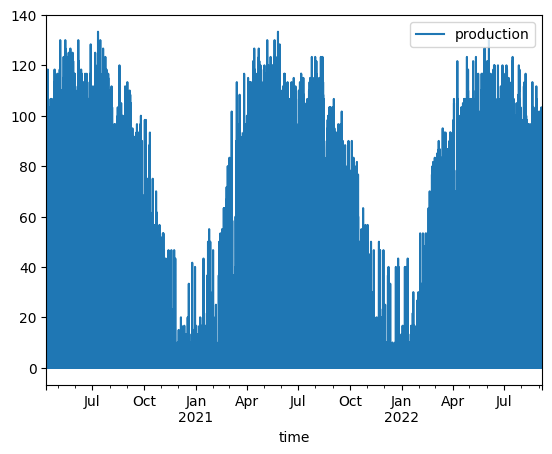

In [43]:
df_production_resampled.plot()

### 3.4. Weer en zonnepanelen combineren
Omdat we de index juist hebben ingesteld op tijd, kunnen we de twee geresamplede tabellen combineren tot een.

In [ ]:
df_merged = df_production_resampled.merge(df_weather_resampled, on='time', how='left')

df_merged['weer'] = df_merged['weer'].interpolate()
df_merged['production'] = df_merged['production'].interpolate()

df_merged

,production,weer
time,,
2020-04-10 10:30:00+00:00,96.666667,6.710796
2020-04-10 10:40:00+00:00,78.333333,6.912627
2020-04-10 10:50:00+00:00,86.666667,7.114458
2020-04-10 11:00:00+00:00,90.000000,7.316289
2020-04-10 11:10:00+00:00,86.666667,7.354273
...,...,...
2022-09-06 16:50:00+00:00,6.666667,8.000000
2022-09-06 17:00:00+00:00,6.666667,8.000000
2022-09-06 17:10:00+00:00,3.333333,8.000000


### 3.5. Filter op zonnige dagen
Om extra factoren zoals een bewolkt tijdstip te voorkomen, filter ik de momenten eruit waar de bewolkingsgraad 1 of meer is (dus lichtbewolkt of erger).

Duidelijke beschrijvingen van de bewolkingsgraad ontbreken uit de tabel van KNMI, maar op de website van de Belgische KMI heb ik hier wel [een artikel over gevonden](https://www.meteo.be/nl/info/weerwoorden/bewolkingsgraad). Deze stelt:
|Term|Bewolkingsgraad in octa's
|-|-
|Heldere hemel|0
|Lichtbewolkt | 1 tot 2
|Halfbewolkt | 3 tot 5
|Zwaarbewolkt | 6 tot 7
|Betrokken | 8

In [52]:
MAX_BEWOLKINGSGRAAD = 1

df_zonnig = df_merged.loc[df_merged['weer'] < MAX_BEWOLKINGSGRAAD]

print(f"We houden nu nog {round(len(df_zonnig) / len(df_merged) * 100)}% over")

df_zonnig

We houden nu nog 12% over


,production,weer
time,,
2020-04-12 00:00:00+00:00,0.000000,7.715901e-01
2020-04-12 00:10:00+00:00,0.000000,7.190440e-01
2020-04-12 00:20:00+00:00,0.000000,6.664979e-01
2020-04-12 00:30:00+00:00,0.000000,6.139518e-01
2020-04-12 00:40:00+00:00,0.000000,5.614057e-01
...,...,...
2022-09-03 17:00:00+00:00,6.666667,1.867937e-317
2022-09-03 17:10:00+00:00,10.000000,7.339437e-01
2022-09-03 22:00:00+00:00,0.000000,2.279036e-01


## 4. Modeling

In [53]:
# Gegeven:
def model_zonnestraling(tilt:float, azimuth:float, tijdsreeks:pd.core.indexes.datetimes.DatetimeIndex, lat:float, lon:float) -> pd.DataFrame:
    """Berekent de hoeveelheid stroom die een paneel maximaal produceert met 100% efficientie"""

    zonne_positie_aan_hemel = pvlib.solarposition.get_solarposition(tijdsreeks, lat, lon)

    #locatie = pvlib.location.Location(latitude=lat, longitude=lon, name='Plaatsnaam', tz=pytz.timezone(r'Europe/Amsterdam'))
    locatie = pvlib.location.Location(latitude=lat, longitude=lon, name='Plaatsnaam', tz=pytz.timezone(r'UTC'))
    heldere_hemel = locatie.get_clearsky(tijdsreeks)

    instraling = pvlib.irradiance.get_total_irradiance(tilt,
                                                       azimuth,
                                                       zonne_positie_aan_hemel['zenith'],
                                                       zonne_positie_aan_hemel['azimuth'],
                                                       heldere_hemel.dni,
                                                       heldere_hemel.ghi,
                                                       heldere_hemel.dhi)

    return instraling['poa_global'].to_frame().rename(columns={'poa_global':'zonlicht'})

In [54]:
# Aanvullen
def model_paneel(tilt:float, azimuth:float, efficientie:float, tijdsreeks:pd.core.indexes.datetimes.DatetimeIndex, lat:float, lon:float) -> pd.DataFrame:
    """Berekent de hoeveelheid geabsorbeerd zonlicht op een paneel op basis van de efficientie"""

    zonnestraling = model_zonnestraling(tilt, azimuth, tijdsreeks, lat, lon)

    return zonnestraling * efficientie

In [55]:
# Aanvullen
def loss(params:Tuple[float,float,float], df_waarneming:pd.DataFrame, lat:float, lon:float) -> float:

    (tilt, azimuth, efficientie) = params

    tijdsreeks = df_waarneming.index

    df_model = model_paneel(tilt, azimuth, efficientie, tijdsreeks, lat, lon) # Aanvullen

    return ((df_model['zonlicht'] - df_waarneming['production'])**2).sum()


In [ ]:
# Eerste inschatting


In [ ]:
# Zwolle, I guess? https://www.latlong.net/
lat = 52.512791
lon = 6.091540

tilt = 35
azimuth = 180
efficientie = 0.2

result = minimize(loss, (tilt, azimuth, efficientie), (df_zonnig, lat, lon)) # Aanvullen
(tilt, azimuth, efficientie) = result['x']

## 5. Evaluation

In [ ]:
print("Tilt:        {0:.1f}°".format(tilt))
print("Azimuth:     {0:.1f}°".format(azimuth))
print("Efficientie: {0:.1f}%".format(efficientie * 100))

Tilt:        12.0°
Azimuth:     230.1°
Efficientie: 11.5%


<Axes: xlabel='time'>

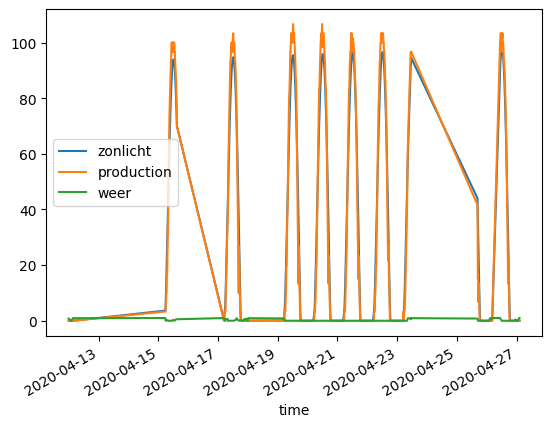

In [ ]:
df_model = model_paneel(tilt, azimuth, efficientie, df_zonnig.index, lat, lon)
df_model['production'] = df_zonnig['production']
df_model['weer'] = df_zonnig['weer']

df_model = df_model.loc['2020-04-01':'2020-04-30']

df_model.plot()